## Introduction

We have learned many cryptographic primitives in lectures. While they are resistant to mathematical attacks, inappropriate implementations can lead to the leakage of secret keys through side-channel effects (such as running times, power consumption, electromagnetic waves, etc.).
In this assignment, we will learn how a side-channel attack can extract the secret key of a mathematically secure cryptographic implementation. This assignment aims to understand how real-world implementations can affect the security of cryptographic applications.

You will face two kinds of questions: short-answer questions and implementation questions. They always start with a red <font color="red">Question xx</font>. There are <b>9 Questions</b> in total.

For short answer questions, please type your answer in the next block (by double-clicking that block).

For implementation questions, please finish the corresponding implementation by typing your code between the comments <font color="green">"Your code starts"</font> and <font color="green">"Your code ends"</font>. Please read the requirements carefully for each question. Failing to follow them will result in 0 marks for the corresponding questions.

The total marks for this assignment are 125, contributing 12.5% to the subject marks.

<b>Evaluation</b>: Your iPython notebook should run end-to-end without any errors in a reasonable amount of time, and you must follow all instructions provided below, including specific implementation requirements and instructions for what needs to be printed (please avoid printing output we don't ask for). You should edit the sections below where requested, but leave the rest of the code as is. You should leave the output from running your code in the iPython notebook you submit, to assist with marking. The amount each section is worth is given in parentheses after the instructions. <b> You should use Python 3</b>. Our marking script is running under Python 3.10.16.

<font color="red">Important 1: Importing any library outside the following list is prohibited! Using any of them will attract 0 mark for all corresponding questions!</font>

<font color="green">Allowed Libraries:
- numpy
- matplotlib
</font>

<font color="red">Important 2: For all variables whose name starts with "answer_", please ensure they are assigned the correct value. They will be treated as your answers and are checked by automatic scripts.</font>

- Question 2: <font color="purple">answer_byte_1</font>.
- Question 2: <font color="purple">answer_highest_coef_for_each_guess</font>
- Question 4: <font color="purple">answer_RK_0</font>
- Question 8: <font color="purple">answer_32bit_RK_14</font>
- Question 9: <font color="purple">answer_32bit_RK_13</font>

<b>Academic misconduct</b>: For most people, collaboration will form a natural part of the undertaking of this homework, and we encourage you to discuss it in general terms with other students. However, this is ultimately still an individual task, and therefore, the reuse of code or other instances of clear influence will be considered cheating. We will be checking submissions for originality and will invoke the University’s Academic Misconduct policy where inappropriate levels of collusion or plagiarism are deemed to have taken place.

---------------------------------------------------------

<font color="green">Please sign your student name and ID there.</font>

By signing my name there, I agree:

   (1) I certify that the program contained in this submission is completely
   my own individual work, except where explicitly noted by comments that
   provide details otherwise.  I understand that work that has been developed
   by another student, or by me in collaboration with other students,
   or by non-students as a result of request, solicitation, or payment,
   may not be submitted for assessment in this subject.  I understand that
   submitting for assessment work developed by or in collaboration with
   other students or non-students constitutes Academic Misconduct, and
   may be penalized by mark deductions, or by other penalties determined
   via the University.

   (2) I also certify that I have not provided a copy of this work in either
   softcopy or hardcopy or any other form to any other student, and nor will
   I do so until after the marks are released. I understand that providing
   my work to other students, regardless of my intention or any undertakings
   made to me by that other student, is also Academic Misconduct.

   (3) I further understand that providing a copy of the assignment
   specification to any form of code authoring or assignment tutoring
   service, or drawing the attention of others to such services and code
   that may have been made available via such a service, may be regarded
   as Student General Misconduct (interfering with the teaching activities
   of the University and/or inciting others to commit Academic Misconduct).
   I understand that an allegation of Student General Misconduct may arise
   regardless of whether or not I personally make use of such solutions
   or sought benefit from such actions.


Student Name: Aaryan Maheshwari

Student ID: 230022

Date: 7th July, 2025

---------------------------------------------------------

## Section 0: Introduction to Side-Channel Attacks and Power Analysis
#### [0 marks]

Please read the following two pages for a brief overview of side-channel attacks and power analysis.

https://www.allaboutcircuits.com/technical-articles/understanding-side-channel-attack-basics/

https://www.allaboutcircuits.com/technical-articles/a-basic-introduction-to-power-based-side-channel-attacks/

Generally speaking, side-channel attacks are a class of attacks that don't directly target the cryptographic algorithm itself. Instead, they exploit unintended physical characteristics of a device, such as power consumption, timing, or electromagnetic emissions. These characteristics can leak information about the internal computations being performed.

Then, power analysis is a specific type of side-channel attack that focuses on the power consumption of a device. Modern electronic devices consume varying amounts of power depending on the operations and operating values they are performing. Attackers can measure these power fluctuations (known as "power traces") using specialized equipment like oscilloscopes or even a single Ampere meter.

#### Correlation Power Analysis ####

Correlation Power Analysis (CPA) is a methodology within power analysis. Specifically, the attacker hypothesizes that the power consumption follows a leakage model.

CPA runs as follows:

1. The attacker determines the hypothesized power consumption leakage model.
2. The attacker hypothesizes a key and uses it to compute the theoretical power consumption under the leakage model.
3. The attacker compares whether the theoretical power consumption matches the real collected power consumption.
4. The attacker repeats the guessing (steps 2 and 3) for all possible keys,
5. The attacker selects the key that yields the best match in terms of power consumption as the final guess.

In this assignment, we utilize the Hamming Weight (HW) leakage model. In other words, we hypothesize that the power consumption at time point $t$ is determined by the HW of the <font color="green">***output***</font> value.


#### Preparsions ####

We are going to extract the AES keys using CPA. Before we start, we list the necessary definitions and dependencies used in this assignment. Please remember them clearly, and do not forget to run the code block!

**HW(data):** the Hamming Weight (HW) of the data. We have already given the implementation to compute HW in the following code block.

**$SK$:** the master secret key of AES.

**$RK_i$:** the round key ($RK$) at round $i$. In this assignment, we always count $RK$ starting from 0, and follow the AES forward operation (encryption) order. Take AES-128 as an example. There are 11 $RK$ in total. In encryption, the first operated $RK$ is $RK_0$, while the last operated $RK$ is $RK_{10}$. In decryption, the first operated $RK$ is $RK_{10}$, while the last operated $RK$ is $RK_0$.

**$Round_i$:** the AES round where $RK_i$ is operated.






In [ ]:
## You can comment this block after you have installed those dependencies.
# pip install numpy matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

SBOX = [
    [0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76],
    [0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0],
    [0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15],
    [0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75],
    [0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84],
    [0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF],
    [0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8],
    [0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2],
    [0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73],
    [0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB],
    [0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79],
    [0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08],
    [0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A],
    [0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E],
    [0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF],
    [0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16]
]

class Traces:
    def __init__(self, traces, text_ins):
        self.traces = traces
        self.text_ins = text_ins

def load_traces(filename):
    data = np.load(filename, allow_pickle=True)
    traces = data['traces']
    text_ins = data['textins']
    return Traces(traces, text_ins)


def print_hex(data):
    return ''.join(f'0x{byte:02x} ' for byte in data)

def HW(data):
    return bin(data).count('1')

def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

----------------------

## Section 1: Attack the AddRoundKey in 8-bit AES-128
#### [15 marks]

Recall the AES-128 implementation in assignment 1. For all AddRoundKey, SubByte, ShiftRow, and MixColumn operations, we operate on the input byte by byte. Such byte-wise AES is 8-bit AES.

We will now extract the master secret key $SK$ of an 8-bit AES-128 encryption machine. We assume we can query the encryption machine with known plaintext and obtain the corresponding power traces while it is running. As AES is a symmetric-key primitive, it is equivalent to getting $SK$ from either encryption or decryption.

Recall that AES-128 utilizes the Rijndael key schedule to expand the master key $SK$ into 11 $RK$ values where $RK_0=SK$. In other words, revealing $RK_0$ directly reveals the $SK$.

Based on the CPA introduced before, we need to enumerate all possible keys for AES. It is impractical because $RK_0$ has a key space of $2^{128}$. However, as it is an 8-bit AES, each byte of $RK_0$ is computed individually with another input byte. By divide-and-conquer, we can recover $RK_0$ byte by byte, reducing the searching space to $2^8 \times 16$.

We will show you how to recover the <font color="green">first byte</font>, then you are asked to recover the <font color="red">second byte</font>.

Let's start with recovering the first byte ($byte_0$ in $RK_0$)!

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

#### Compute the theoretical power consumption with hypothesized keys. ####

To recover $RK_0$, the first relevant operation is the AddRoundKey in $Round_0$, where the output is computed with a known input plaintext and unknown $RK_0$. We are now targeting the output of this AddRoundKey to perform the CPA.

<font color="red" size="4">Question 1:</font> [5 mark] Compute the theoretical power consumption of AddRoundKey for $byte_i$ in the plaintext with a hypothesized key byte. Recall that we utilize the Hamming Weight (HW) leakage model to represent the theoretical power consumption.

In [ ]:
## input: plaintext
## input: plaintext byte index
## input: a hypothesized key byte
## output: the theoretical power consumption (HW(output))
def theoretical_power_consumption_for_byte_i_Section_1(plaintext, byte_index, hypothesized_key_byte):
    power_consumption = 0
    ## You code starts"

    plaintext_byte = plaintext[byte_index]
    output_byte = plaintext_byte ^ hypothesized_key_byte
    power_consumption = HW(output_byte & 0xFF)

    ##"You code ends"
    return power_consumption

In [ ]:
## For your check
test_plaintext = [i for i in range(16)]
assert theoretical_power_consumption_for_byte_i_Section_1(test_plaintext, 0, 0xf1) == 5

#### Collect the power traces ####

We have collected the power traces for you. They are collected from a C-version implementation, which is equivalent to assignment 1. If you are interested in the source code, we have attached the corresponding C implementation in the file *AES-8bit.c* for viewing. There are 100 power traces collected from encrypting 100 random plaintexts with an unknown fixed key. After loading the traces, you can view $trace_i$ by Traces.traces[i] and its corresponding input plaintext by Traces.text_ins[i].

The input plaintext:


'0xce 0x6b 0x58 0x34 0x67 0xd5 0xe6 0x48 0x21 0x32 0xa8 0x5f 0x5f 0x65 0x4e 0xbe '

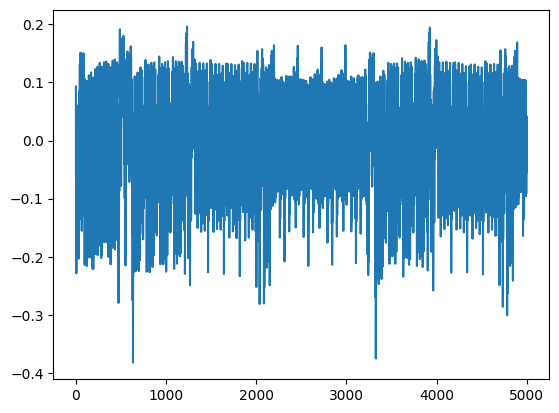

In [ ]:
## Load traces
traces_8_bit = load_traces("AES-8-attack.npz")

## Get and view the trace_0
trace_0 = traces_8_bit.traces[0]
plt.plot(trace_0)

## Get and view the input plaintext for trace_0
plaintext_0 = traces_8_bit.text_ins[0]
print("The input plaintext:")
print_hex(plaintext_0)

#### Compares whether the theoretical power consumption matches the real collected power consumption ####

There are two main challenges in determining whether the theoretical power consumption matches the actual measured power data.

First, we don't know the exact values of the actual power consumption. What we use instead is a model — for example, we often estimate power based on the Hamming weight of the output. This is just an approximation and not the real measured power.

Second, we don’t know the exact time when the AddRoundKey operation occurs. Even if we can compute the theoretical power values for a guessed key, we don’t know the precise moment in the trace to compare them with.

To address the first challenge, we measure the linear correlation between the theoretical and actual power consumption to determine if there is a match. In other words, if the variation pattern of the theoretical power consumption closely follows the trend of the actual measured values as the input changes, it suggests that we've likely guessed the correct key.

To quantify this, we use the absolute value of the Pearson Correlation Coefficient, which ranges from 0 to 1. A value of 0 means there is no correlation, while a value of 1 indicates a perfect linear correlation.

The actual algorithm is as follows for datasets $X$ and $Y$ of length $N$, with means of $\bar{X}$ and $\bar{Y}$, respectively:

$$coef = |\frac{cov(X, Y)}{\sigma_X \sigma_Y}|$$
    
$cov(X, Y)$ is the covariance of `X` and `Y` and can be calculated as follows:
    
$$cov(X, Y) = \sum_{n=1}^{N}[(Y_n - \bar{Y})(X_n - \bar{X})]$$
    
$\sigma_X$ and $\sigma_Y$ are the standard deviations of the two datasets. This value can be calculated with the following equation
    
$$\sigma_X = \sqrt{\sum_{n=1}^{N}(X_n - \bar{X})^2}$$

We have provided the $cov$ implementation as $cov(X, \bar{X}, Y, \bar{Y})$. See the usage example and how to compute the Absolute Pearson Correlation Score.

In [ ]:
## X: Theoretical power consumption at time t with input plaintext pt_0, pt_1, pt_2, pt_3, pt_4 and key_0
power_example_t = np.array([[4, 2, 9, 6, 8], [2, 2, 3, 2, 2]]).transpose()

## Y: Actual power consumption at time t with input plaintext pt_0, pt_1, pt_2, pt_3, pt_4 and key_0
power_example_a = np.array([[0.1, 0.444, 0.124124, 0.885, 0.6545]]).transpose()

## std for X and Y
std_power_example_t = std_dev(power_example_t, mean(power_example_t))
std_power_example_a = std_dev(power_example_a, mean(power_example_a))

## cov(X, mean(X), Y, mean(Y))
at_cov = cov(power_example_t, mean(power_example_t), power_example_a, mean(power_example_a))

## Absolute Pearson Correlation Score
Pearson_coef = np.abs(at_cov/(std_power_example_t*std_power_example_a))
print(Pearson_coef)

[0.0378418  0.52355145]


To address the second challenge, we can look at each time point one by one and calculate the correlation between the power measurements and the hypothetical power consumption based on a guessed key.
If the guessed key is correct, we should see a strong peak (a clear high correlation) at some time point. If the key is wrong, the correlation values will be low and similar across all time points, without any noticeable peaks.

We have provided the implementations below.

In [ ]:
## compute the theoretical power consumption for all plaintexts at byte_i
def theoretical_power_consumption_Section_1(plaintexts, byte_index, key_byte):
    return [theoretical_power_consumption_for_byte_i_Section_1(plaintext, byte_index, key_byte) for plaintext in plaintexts]

## we can pre-compute the std and mean for the actual power consumption at each time t to speed up computation
mean_actuals = mean(traces_8_bit.traces)
std_actuals = std_dev(traces_8_bit.traces, mean_actuals)

## input: traces - collected power traces (2-D np array)
## input: text_ins -  inputs for the collected power traces (2-D np array)
## input: guessed_byte_index - target key byte to be recovered
## input: guessed_key_byte - hypothesized value for the key byte
## input: mean_actuals - pre-computed means for the collected power traces
## input: std_actuals - pre-computed stds for the collected power traces
## output: Pearson Correlation Coefficients among the time points (1-D array)
def compute_coefs_for_a_guess(traces, text_ins, guessed_byte_index, guessed_key_byte, mean_actuals, std_actuals):
    ## Be careful about the shape and the transpose of power_theoretical there !!!!!!
    power_theoretical = np.array([theoretical_power_consumption_Section_1(text_ins, guessed_byte_index, guessed_key_byte)]).transpose()
    mean_theoretical = mean(power_theoretical)
    std_hws = std_dev(power_theoretical, mean_theoretical)
    coefs = np.abs(cov(traces, mean_actuals, power_theoretical, mean_theoretical)/(std_actuals*std_hws))
    return coefs

Let's begin to guess $byte_0$ of $RK_0$! For demonstration purposes, we already know $byte_0$=0x2b. After plotting the coefficients along the time points, we can see an extreme peak.

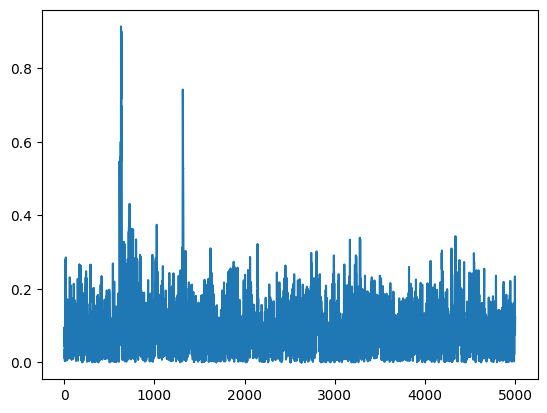

In [ ]:
guessed_key_byte = 0x2b
guessed_byte_index = 0

coefs = compute_coefs_for_a_guess(traces_8_bit.traces, traces_8_bit.text_ins, guessed_byte_index, guessed_key_byte, mean_actuals, std_actuals)
plt.plot(coefs)

Otherwise, if we guseed an incorrect key (say, 0x3e), there will be no such a peak.

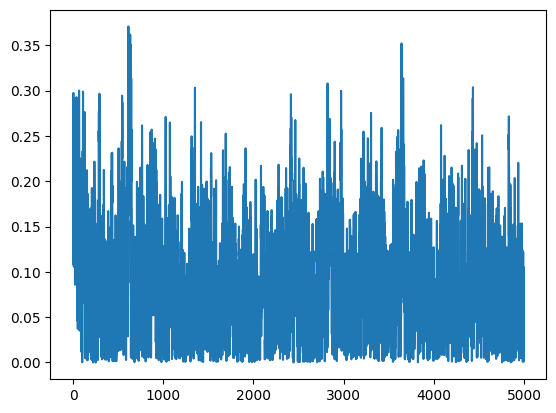

In [ ]:
guessed_key_byte = 0x3e
guessed_byte_index = 0

coefs = compute_coefs_for_a_guess(traces_8_bit.traces, traces_8_bit.text_ins, guessed_byte_index, guessed_key_byte, mean_actuals, std_actuals)
plt.plot(coefs)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

#### Recover the $byte_1$ for $RK_0$ ####

<font color="red" size="4">Question 2:</font> [10 mark] Now, you are required to finish the following block to recover the second byte ($byte_1$ for $RK_0$). You can reuse the implementations we have provided above.

*(Hint: We only need to record and compare the highest coef between each key guess)*

- For our automatic script check, please assign your $byte_1$ value back to the <font color="purple">answer_byte_1</font>.
- For our automatic script check, please record the highest coefficient value for each key in <font color="purple">answer_highest_coef_for_each_guess_byte_1</font>. Keep the list indexed by the key value. (i.e.answer_highest_coef_for_each_guess_byte_1[1] is the coefficient value for key=0x01)

0x81


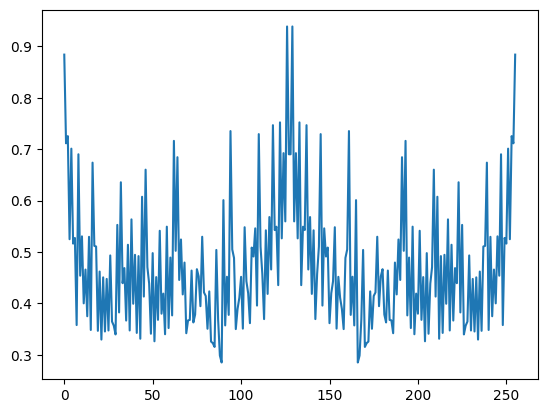

In [ ]:
answer_byte_1 = 0
answer_highest_coef_for_each_guess_byte_1 = []
## Your code starts

guessed_byte_index = 1
for guessed_key_byte in range(256):
    coefs = compute_coefs_for_a_guess(traces_8_bit.traces, traces_8_bit.text_ins, guessed_byte_index, guessed_key_byte, mean_actuals, std_actuals)
    answer_highest_coef_for_each_guess_byte_1.append(max(coefs))
    if max(coefs) == max(answer_highest_coef_for_each_guess_byte_1):
        answer_byte_1 = guessed_key_byte

## Your code ends

print(hex(answer_byte_1))
plt.plot(answer_highest_coef_for_each_guess_byte_1)

<font color="red" size="4">*</font> <font color="green"> Have you got the correct $byte_1$=0x7e? In fact, you should not get the correct value. Let's leave it for a while. </font>

-----------------

## Section 2: Attack the SubByte in 8-bit AES-128
#### [60 marks]

In fact, attacking AddRoundKey does not work well. We now turn our focus to the next operation, SubByte in $Round_1$. Although it belongs to $Round_1$, no additional unknown secrets are introduced. As a result, we can utilize the power consumption of this SubByte's outputs to recover $RK_0$ by simply repeating the previous attack.

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

<font color="red" size="4">Question 3:</font> [5 mark] First of all, we need to compute the theoretical power consumption for the SubByte operation. Finish the implementation below:

In [ ]:
## input: plaintext
## input: plaintext byte index
## input: a hypothesized key byte
## output: the theoretical power consumption (HW(output))
def theoretical_power_consumption_for_byte_i_Section_2(plaintext, byte_index, hypothesized_key_byte):
    power_consumption = 0
    ## Your code starts

    val = plaintext[byte_index] ^ hypothesized_key_byte
    output_byte = SBOX[(val >> 4) & 0x0F][val & 0x0F]
    power_consumption = HW(output_byte)


    ## Your code ends
    return power_consumption

In [ ]:
## for your check
test_plaintext = [i for i in range(16)]
assert theoretical_power_consumption_for_byte_i_Section_2(test_plaintext, 0, 0xf1) == 3

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

<font color="red" size="4">Question 4:</font> [20 mark] Now, you are asked to recover the whole $RK_0$, and store each byte's value back to the <font color="purple">answer_RK_0</font> list.

You can insert as many code blocks as you need between the <font color="green">Your code starts</font> and <font color="green">Your code ends</font>. You can reuse the implementations we have provided before.

In [ ]:
answer_RK_0 = [0 for i in range(16)]

In [ ]:
## Your code starts

In [ ]:
## compute the theoretical power consumption for all plaintexts at byte_i
def theoretical_power_consumption_Section_2(plaintexts, byte_index, key_byte):
    return [theoretical_power_consumption_for_byte_i_Section_2(plaintext, byte_index, key_byte) for plaintext in plaintexts]

## we can pre-compute the std and mean for the actual power consumption at each time t to speed up computation
mean_actuals = mean(traces_8_bit.traces)
std_actuals = std_dev(traces_8_bit.traces, mean_actuals)

## input: traces - collected power traces (2-D np array)
## input: text_ins -  inputs for the collected power traces (2-D np array)
## input: guessed_byte_index - target key byte to be recovered
## input: guessed_key_byte - hypothesized value for the key byte
## input: mean_actuals - pre-computed means for the collected power traces
## input: std_actuals - pre-computed stds for the collected power traces
## output: Pearson Correlation Coefficients among the time points (1-D array)
def compute_coefs_for_a_guess_section_2(traces, text_ins, guessed_byte_index, guessed_key_byte, mean_actuals, std_actuals):
    ## Be careful about the shape and the transpose of power_theoretical there !!!!!!
    power_theoretical = np.array([theoretical_power_consumption_Section_2(text_ins, guessed_byte_index, guessed_key_byte)]).transpose()
    mean_theoretical = mean(power_theoretical)
    std_hws = std_dev(power_theoretical, mean_theoretical)
    coefs = np.abs(cov(traces, mean_actuals, power_theoretical, mean_theoretical)/(std_actuals*std_hws))
    return coefs

In [ ]:
for byte_index in range(16):
  answer_highest_coef_for_each_guess = []
  for guessed_key_byte in range(256):
    coefs = compute_coefs_for_a_guess_section_2(traces_8_bit.traces, traces_8_bit.text_ins, byte_index, guessed_key_byte, mean_actuals, std_actuals)
    answer_highest_coef_for_each_guess.append(max(coefs))
    if max(coefs) == max(answer_highest_coef_for_each_guess):
        answer_RK_0[byte_index] = guessed_key_byte


In [ ]:
print([hex(b) for b in answer_RK_0])

['0x2b', '0x7e', '0x15', '0x16', '0x28', '0xae', '0xd2', '0xa6', '0xab', '0xf7', '0x15', '0x88', '0x9', '0xcf', '0x4f', '0x3c']


In [ ]:
## Your code ends

You should be able to correctly recover the whole $RK_0$ now! Because $SK=RK_0$, we have revealed the AES master secret key!

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

<font color="red" size="4">Question 5:</font> [15 mark]
Attacking the results of AddRoundKey is not effective, as it sometimes recovers incorrect key values. By contrast, attacking the results of SubByte gives us the correct key. Explain why AddRoundKey is not an effective attacking target, but SubByte is.

*(Hint: Think of the figure about the highest_coef_for_each_guess in Question 2.)*

**Answer:**

Attacking $\texttt{AddRoundKey}$ is ineffective because it performs a simple bitwise XOR between the plaintext byte and key byte. The Hamming weight of the XOR result lacks nonlinearity and varies weakly across different key guesses, producing low or ambiguous correlation with actual power consumption. This makes distinguishing the correct key guess from incorrect ones difficult, especially in noisy environments or with limited traces.

In contrast, $\texttt{SubByte}$ applies a nonlinear S-box transformation to the XOR result. This nonlinearity amplifies small differences in key guesses, causing the Hamming weight of the SubByte output to correlate strongly with actual power usage when the correct key is used. As a result, correlation peaks clearly at the correct key byte, enabling reliable recovery via differential power analysis.


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

<font color="red" size="4">Question 6:</font> [10 mark]
Based on this attack, Alice proposes a countermeasure that never reuses $SK$ in any AES round ($RK_i\neq SK$), so that $SK$ can never be obtained in any single round. Does it prevent the attacker from getting the value of $SK$? Explain why or why not.

**Answer:**

No, it does not prevent the attacker from obtaining the value of $SK$.

Changing the round keys $(RK_i \neq SK)$ does not obscure the fact that all round keys are deterministically derived from $SK$ using the AES key schedule. An attacker can still recover the round keys $(RK_0, RK_1, \text{etc.})$ using side-channel attacks on operations like $\texttt{SubByte}$ in early rounds. Once any sufficient portion of the expanded key is recovered (e.g., $RK_0$), the attacker can invert the AES key schedule to reconstruct the original secret key $SK$.

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

<font color="red" size="4">Question 7:</font> [10 mark]
Based on this attack, Bob proposes a countermeasure that uses a non-invertible key schedule and $RK_i\neq SK$ in AES, so that $SK$ can never be obtained in any single round. Does it work to guarantee the security of AES? Explain why or why not.

**Answer:**

No, this does not guarantee the security of AES.

A non-invertible key schedule and ensuring
$RK_i\neq SK$ only prevent direct recovery of the secret key
$SK$ through inversion of the key schedule. However, side-channel attacks like Differential Power Analysis (DPA) do not require recovery of $SK$ itself; they target key-dependent intermediate values (e.g., $\texttt{SubByte}$ output after $\texttt{AddRoundKey}$). These values are computed using the round keys $RK_i$, not $SK$ directly.

If an attacker can recover any $RK_i$	via side-channel leakage, and those round keys are sufficient to encrypt or decrypt data, then the cryptographic security is already compromised. Even with a non-invertible key schedule, the attacker may still recover round keys from physical leakage, use round keys to perform encryption/decryption and
mount further attacks if round keys are reused




-----------------

## Section 3: Attack 32-bit AES-256 Decryption.
#### [50 marks]

Now, let's turn our focus to extracting the secret keys for a 32-bit AES-256 if we can get access to its decryption machine.

In fact, modern processor architectures can operate a 32/64/128-bit value inside one instruction. To speed up the running time, the 32-bit version AES splits the 128-bit state block into four 32-bit words, instead of 16 8-bit words. Then, different from our 8-bit implementations in assignment 1, it performs AddRoundKey, SubByte, ShiftRow, and MixColumn on every 32-bit word.

Different from AES-256 encryption, AES-256 decryption operates on keys starting from $RK_{14}$. Recall that $SK=[RK_0, RK_1]$ in AES-256, one way is to keep recovering until $RK_1$ and $RK_0$. However, getting $RK_{14}$ and $RK_{13}$ is equivalent to getting $SK$.

We selected 500 ciphertexts and collected their power traces from an AES-256 decryption machine with a fixed unknown $SK$. <font color="green">The AES-256 decryption is implemented from *'AES-32bit.c'* between line 966 and line 1021 (int mbedtls_internal_aes_decrypt(arguments))</font>. You need to read this decryption implementation carefully and design the CPA to recover $RK_{14}$ and $RK_{13}$.

*(Hint1: Do not try to enumerate $2^{32}$ keys! You can still recover $RK$ byte by byte. However, you need to carefully think about what the output is and then compute the correct theoretical power consumption.)*

*(Hint2: One way to check your correctness is to utilize your CPA to recover $RK_{12}$, and compare it with the $RK'_{12}$ computed from your recovered $RK_{14}$ and $RK_{13}$ to see whether they match)*

*(Hint3: it takes longer time to recover one $RK$ there. Depending on your CPA implementation, it can take a few minutes.)*

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

The traces are loaded for you:

In [ ]:
traces_32_bit = load_traces("AES-32-attack.npz")

<font color="red" size="4">Question 8:</font> [25 mark] Recovering the $RK_{14}$, and store each byte's value back to the <font color="purple">answer_32bit_RK_14</font> list.

You can insert as many code blocks as you need between the <font color="green">Your code starts</font> and <font color="green">Your code ends</font>. You can reuse the implementations we have provided before.

In [ ]:
answer_32bit_RK_14 = [0 for i in range(16)]

In [ ]:
## Your code starts

In [ ]:
INV_SBOX = [0] * 256
for i in range(16):
    for j in range(16):
        val = SBOX[i][j]
        INV_SBOX[val] = (i << 4) | j

In [ ]:
## Your code starts

answer_32bit_RK_14 = []

# Theoretical power model for final AES decryption round using 2D SBOX
def theoretical_power_consumption_for_byte_i_final_round(ciphertext, byte_index, hypothesized_key_byte):
    val = ciphertext[byte_index] ^ hypothesized_key_byte
    output_byte = INV_SBOX[val]
    return HW(output_byte)

def theoretical_power_consumption_final_round(ciphertexts, byte_index, key_byte):
    return [theoretical_power_consumption_for_byte_i_final_round(ct, byte_index, key_byte) for ct in ciphertexts]

# Compute correlation coefficients
def compute_coefs_for_a_guess_final(traces, ciphertexts, guessed_byte_index, guessed_key_byte, mean_actuals, std_actuals):
    power_theoretical = np.array([theoretical_power_consumption_final_round(ciphertexts, guessed_byte_index, guessed_key_byte)]).transpose()
    mean_theoretical = mean(power_theoretical)
    std_hws = std_dev(power_theoretical, mean_theoretical)
    coefs = np.abs(cov(traces, mean_actuals, power_theoretical, mean_theoretical) / (std_actuals * std_hws))
    return coefs

# Load 32-bit traces
traces_32 = traces_32_bit.traces
ciphertexts_32 = traces_32_bit.text_ins
mean_actuals_32 = mean(traces_32)
std_actuals_32 = std_dev(traces_32, mean_actuals_32)

# Recover RK14 one byte at a time
for byte_index in range(16):
    max_coef = -1
    best_guess = 0
    for guessed_key_byte in range(256):
        coefs = compute_coefs_for_a_guess_final(traces_32, ciphertexts_32, byte_index, guessed_key_byte, mean_actuals_32, std_actuals_32)
        current_max = max(coefs)
        if current_max > max_coef:
            max_coef = current_max
            best_guess = guessed_key_byte
    answer_32bit_RK_14.append(best_guess)

## Your code ends


In [ ]:
## Your code ends
print([hex(b) for b in answer_32bit_RK_14])

['0xf0', '0xcd', '0x54', '0xe9', '0xaa', '0xea', '0x9e', '0x41', '0x43', '0x38', '0xfc', '0x6d', '0x6f', '0xf6', '0x15', '0x88']


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

<font color="red" size="4">Question 9:</font> [25 mark] Recovering the $RK_{13}$, and store each byte's value back to the <font color="purple">answer_32bit_RK_13</font> list.

You can insert as many code blocks as you need between the <font color="green">Your code starts</font> and <font color="green">Your code ends</font>. You can reuse the implementations we have provided before.

In [ ]:
answer_32bit_RK_13 = [0 for i in range(16)]

In [ ]:
## Your code starts

In [ ]:
answer_32bit_RK_13 = []

## Your code starts

def theoretical_power_consumption_32bit_RK13(ciphertext, byte_index, hypothesized_key_byte):
    # Step 1: AddRoundKey with RK14 (already recovered)
    after_rk14 = ciphertext[byte_index] ^ answer_32bit_RK_14[byte_index]

    # Step 2: InvSubBytes
    after_inv_subbytes = INV_SBOX[after_rk14]

    # Step 3: Compute full InvSubBytes state
    state_after_inv_subbytes = [INV_SBOX[ciphertext[i] ^ answer_32bit_RK_14[i]] for i in range(16)]

    # Step 4: InvShiftRows
    state_after_inv_shiftrows = [0] * 16
    for i in range(16):
        row = i % 4
        col = i // 4
        new_col = (col + row) % 4
        new_index = new_col * 4 + row
        state_after_inv_shiftrows[new_index] = state_after_inv_subbytes[i]

    # Step 5: AddRoundKey with guessed RK13 byte
    after_rk13 = state_after_inv_shiftrows[byte_index] ^ hypothesized_key_byte

    # Step 6: InvSubBytes (leakage source)
    final_output = INV_SBOX[after_rk13]

    return HW(final_output)

def theoretical_power_consumption_32bit_RK13_list(ciphertexts, byte_index, key_byte):
    return [theoretical_power_consumption_32bit_RK13(ct, byte_index, key_byte) for ct in ciphertexts]

def compute_coefs_32bit_RK13(traces, text_ins, guessed_byte_index, guessed_key_byte, mean_actuals, std_actuals):
    power_theoretical = np.array([theoretical_power_consumption_32bit_RK13_list(text_ins, guessed_byte_index, guessed_key_byte)]).transpose()
    mean_theoretical = mean(power_theoretical)
    std_hws = std_dev(power_theoretical, mean_theoretical)
    coefs = np.abs(cov(traces, mean_actuals, power_theoretical, mean_theoretical) / (std_actuals * std_hws))
    return coefs

# Load data
traces_32 = traces_32_bit.traces
ciphertexts_32 = traces_32_bit.text_ins
mean_actuals_32 = mean(traces_32)
std_actuals_32 = std_dev(traces_32, mean_actuals_32)

# Recover each byte of RK13
for byte_index in range(16):
    max_coef = -1
    best_guess = 0
    for guessed_key_byte in range(256):
        coefs = compute_coefs_32bit_RK13(traces_32, ciphertexts_32, byte_index, guessed_key_byte, mean_actuals_32, std_actuals_32)
        current_max = max(coefs)
        if current_max > max_coef:
            max_coef = current_max
            best_guess = guessed_key_byte
    answer_32bit_RK_13.append(best_guess)

## Your code ends


In [ ]:
## Your code ends
print([hex(b) for b in answer_32bit_RK_13])

['0x21', '0xbe', '0x28', '0x3b', '0xe6', '0xab', '0x5', '0x9d', '0x94', '0xf3', '0x25', '0x57', '0x1', '0x9a', '0xda', '0x38']


--------------------------------------------

End of this Assignemnt